In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.signal import butter, filtfilt

2025-01-17 21:35:57.671077: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 21:35:57.698979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737124557.717023   79445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737124557.722128   79445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 21:35:57.746840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Set up GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


In [3]:
def high_pass_filter_2d(data, cutoff, fs, order, axis):
    """
    Apply a high-pass Butterworth filter to 2D data along a specified axis.
    Args:
        data: 2D array (rows, cols).
        cutoff: Cutoff frequency (Hz).
        fs: Sampling frequency (Hz).
        order: Filter order.
        axis: Axis along which to apply the filter (0 for rows, 1 for columns).
    Returns:
        High-pass filtered 2D array.
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='highpass')
    return filtfilt(b, a, data, axis=axis)

def load_h5_data(filename, dataset_name="dataset"):
    """
    Load data from an HDF5 file.

    Parameters:
    - filename (str): The name of the HDF5 file to load.
    - dataset_name (str): The name of the dataset to load. Default is 'dataset'.

    Returns:
    - numpy.ndarray: The data loaded from the HDF5 file.
    """
    try:
        with h5py.File(filename, "r") as h5f:
            # Check if the dataset exists
            if dataset_name not in h5f:
                raise KeyError(f"Dataset '{dataset_name}' not found in the file.")
            
            # Load the dataset
            data = h5f[dataset_name][:]
            
        print(f"Data successfully loaded from '{filename}', dataset '{dataset_name}'.")
        print(f"Data shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def get_shot_data(data, shot_id, num_trace):
    start_id =  shot_id*num_trace
    end_id   = start_id + num_trace
    return data[:, start_id:end_id]
    
from scipy.signal import butter, filtfilt

def normalized_mean_spectrum(data, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    # Mean spectrum across all traces
    mean_spectrum = np.mean(amplitude_spectrum, axis=1)
    
    # Normalize the mean spectrum
    normalized_mean_spectrum = mean_spectrum / np.max(mean_spectrum)

    return positive_freq, normalized_mean_spectrum

def mean_spectrum(data, sampling_rate):
    """
    Plots the normalized mean spectrum of frequency for a 2D seismic shot gather.
    
    Parameters:
    - data: 2D numpy array (time samples x traces), seismic shot gather data.
    - sampling_rate: Sampling rate in Hz (number of samples per second).
    """
    # Number of time samples and traces
    n_samples, n_traces = data.shape
    
    # Fourier transform along the time axis (axis=0)
    fft_data = np.fft.fft(data, axis=0)
    
    # Calculate the frequency axis
    freq = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    
    # Only keep the positive frequencies
    positive_freq = freq[:n_samples // 2]
    positive_fft = fft_data[:n_samples // 2, :]
    
    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(positive_fft)
    
    # Mean spectrum across all traces
    mean_spectrum = np.mean(amplitude_spectrum, axis=1)
    
    return positive_freq, mean_spectrum

def amplitude_spectrum_loss(y_true, y_pred):
    # Reshape to ensure proper dimensions for FFT
    y_true = tf.squeeze(y_true, axis=-1)  # Remove the last dimension (128, 128)
    y_pred = tf.squeeze(y_pred, axis=-1)  # Remove the last dimension (128, 128)

    # Perform FFT along the second axis (columns)
    true_spectrum = tf.signal.fft(tf.cast(y_true, tf.complex64))
    pred_spectrum = tf.signal.fft(tf.cast(y_pred, tf.complex64))

    # Compute the amplitude spectrum (magnitude of the complex number)
    true_amplitude = tf.abs(true_spectrum)
    pred_amplitude = tf.abs(pred_spectrum)

    # Return the mean squared error of the amplitude spectrum
    return tf.reduce_mean(tf.square(true_amplitude - pred_amplitude))

def hybrid_loss(y_true, y_pred):
    # MAE Loss
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Amplitude Spectrum Loss
    spec_loss = amplitude_spectrum_loss(y_true, y_pred)
    
    # Combine the two losses (you can adjust the weighting factor here)
    total_loss = mae_loss + 0.01 * spec_loss
    return total_loss

# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.8  # Reduce it further after epoch 20

## Loading Data and Models

In [4]:
# filename_data = "../data/datasets/outputs/raw_patches_norm.h5"
# raw_data = load_h5_data(filename_data, dataset_name="dataset")
raw_data = np.load("../data/datasets/outputs/raw_from_paper.npy")

## QC Function for generated Self-Supervised Learning

In [17]:
from scipy import signal
def highpass_filter(data, freq, dt, pad=None):
    """
    Perform high-pass filter on data using SciPy.
    Args:
        freq (float): The cut-off frequency (in Hz).
        data (np.ndarray): Data to be filtered, shape (..., nt, :), where nt = number of time samples.
        dt (float): Time sampling rate of the data (in seconds).
        pad (int, optional): Padding size (before and after, with zeros) before filter.
                             Defaults to None (no padding).
    Returns:
        np.ndarray: High-pass filtered data.
    """
    # Apply padding if specified
    if pad is not None:
        pad_width = [(0, 0)] * (data.ndim - 2) + [(pad, pad), (0, 0)]
        data = np.pad(data, pad_width, mode='reflect')

    # Design the high-pass Butterworth filter
    nyquist = 0.5 / dt  # Nyquist frequency
    sos = signal.butter(7, freq / nyquist, btype='highpass', output='sos')

    # Apply the filter
    filtered_data = signal.sosfiltfilt(sos, data, axis=-2)

    # Remove padding if applied
    if pad is not None:
        filtered_data = filtered_data[..., pad:-pad, :]

    return filtered_data

def preprocess_highpass_filter(data, freq, dt, pad=8):
    """
    TensorFlow wrapper for high-pass filtering using tf.py_function.
    Args:
        data (tf.Tensor): Input data tensor of shape (..., nt, :).
        freq (tuple): Tuple (min_freq, max_freq) defining the range of cutoff frequencies in Hz.
        dt (float): Time sampling interval in seconds.
        pad (int): Padding size for filtering.
    Returns:
        tf.Tensor: Filtered data tensor.
    """
    def filter_fn(data_np):
        # Generate a random frequency within the range
        freq_cut = np.random.uniform(freq[0], freq[1])
        return highpass_filter(data_np, freq_cut, dt, pad)

    # Use tf.py_function to call the filtering function
    filtered_data = tf.py_function(filter_fn, [data], tf.float32)
    # Preserve shape information (important for TensorFlow pipelines)
    filtered_data.set_shape(data.shape)

    return filtered_data
    
def SSL_dataset(model, data, freq_cut_raw, freq_cut_input, dt, batch_size=64):
    """
    Processes a dataset, applies high-pass filtering, generates model-based labels,
    and combines them into a single dataset for model training.

    Parameters:
        model: Trained model for generating labels.
        data: Input data, convertible to a TensorFlow dataset.
        freq_cut_raw: High-pass filter cutoff frequency for raw data.
        freq_cut_input: High-pass filter cutoff frequency for model labels.
        dt: Time step for filtering.
        batch_size: Batch size for dataset batching (default: 64).

    Returns:
        combined_dataset: A tf.data.Dataset with (input, label) pairs, ready for model training.
    """
    # Step 1: Process raw data and apply the high-pass filter
    raw_data_tf = (
        tf.data.Dataset.from_tensor_slices(data)
        .map(
            lambda x: preprocess_highpass_filter(x, freq_cut_raw, dt),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .map(lambda x: tf.expand_dims(x, axis=-1))  # Add channel dimension
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # Step 2: Generate model predictions (labels)
    label_data = model.predict(raw_data_tf, batch_size=batch_size)
    #Squeeze to make compatible for HF function
    label_data = tf.squeeze(label_data, axis=-1)

    # Step 3: Process model predictions for input data
    input_data = (
        tf.data.Dataset.from_tensor_slices(label_data)
        .map(
            lambda x: preprocess_highpass_filter(x, freq_cut_input, dt),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .map(lambda x: tf.expand_dims(x, axis=-1))  # Add channel dimension
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # Step 4: Combine input_data and label_data into a single dataset
    label_data_tf = (
        tf.data.Dataset.from_tensor_slices(label_data)  # Convert labels to tf.data.Dataset
        # .map(
        #     lambda x: preprocess_highpass_filter(x, freq_cut_label, dt),
        #     num_parallel_calls=tf.data.AUTOTUNE,
        # )
        .map(lambda x: tf.expand_dims(x, axis=-1))  # Add channel dimension
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    combined_dataset = tf.data.Dataset.zip((input_data, label_data_tf)).prefetch(tf.data.AUTOTUNE)

    return combined_dataset

freq_cut_raw = (5, 7)
freq_cut_input = (5, 15)
dt = 0.002
filename_model_loading = "Final_Model_L2L_Data_Paper.keras"
model = tf.keras.models.load_model(f"/mnt/d/01_Project/00_LF_Extrapolation_Research/models/{filename_model_loading}", compile=False)
dataset = SSL_dataset(model, raw_data[:128, :, :], freq_cut_raw, freq_cut_input, dt, batch_size=64)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


2025-01-17 21:44:17.908212: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


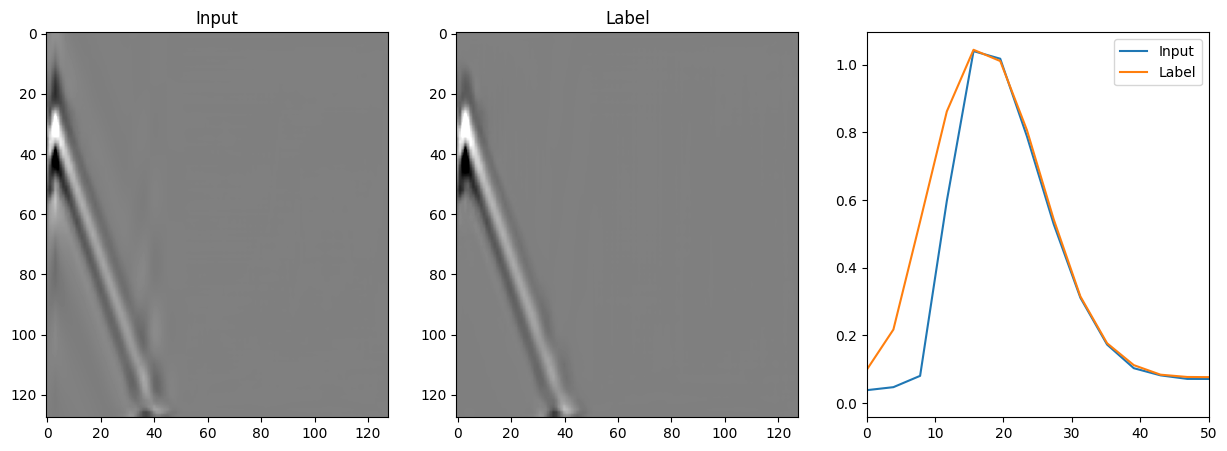

In [18]:
sampling_rate = 1 / (2e-3)
sampel = dataset.take(1)
cval = 0.5
plt.close("all")
idx_trace = 0
for (xx, yy) in sampel:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(xx[idx_trace], aspect="auto", cmap="gray", vmin=-cval, vmax=cval)
    plt.subplot(1, 3, 2)
    plt.title("Label")
    plt.imshow(yy[idx_trace], aspect="auto", cmap="gray", vmin=-cval, vmax=cval)

    freq, spect_input = mean_spectrum(np.squeeze(xx[idx_trace]), sampling_rate)
    freq, spect_output = mean_spectrum(np.squeeze(yy[idx_trace]), sampling_rate)
    freq, spect_raw = mean_spectrum(np.squeeze(raw_data[idx_trace]), sampling_rate)
    plt.subplot(1, 3, 3)
    plt.plot(freq, spect_input, label="Input")
    plt.plot(freq, spect_output, label="Label")
    # plt.plot(freq, spect_raw, label="Raw")
    plt.legend()
    plt.xlim(0, 50)

In [20]:
num_iteration = 50

dt = 0.002  # Time sampling interval in seconds
freq_cut_raw = (5, 10)
freq_cut_input = (5, 9)
# freq_cut_label = (2, 3)

filename_model_loading = "Model_SSL_v11_syn_50_epoch.keras"
model = tf.keras.models.load_model(f"/mnt/d/01_Project/00_LF_Extrapolation_Research/models/{filename_model_loading}", compile=False)

# Define the callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.8*3e-4), loss=hybrid_loss, metrics=['mae'])

filename_model_saving = "Model_SSL_v11_syn_100_epoch_max_9_epoch.keras"
for i in range(num_iteration):
    #generate new dataset --> less low - low 
    print(f"Iteration of Self-Supervised Learning(SSL) {i+1}/{num_iteration}")
    print(f"Construct the less-low dataset! Predicted...")
    
    dataset = SSL_dataset(model, raw_data, freq_cut_raw, freq_cut_input, dt, batch_size=64)
    
    print(f"Construction done.")
    print(f"Optimized Networks...")
    model.fit(dataset, epochs=1, verbose=1)
    
    print(f"Optimized Networks for iteration {i+1}/{num_iteration} done.")
    print("Saving Models")
    
    model.save(f"/mnt/d/01_Project/00_LF_Extrapolation_Research/models/{filename_model_saving}")
    print(f"--------------------")

Iteration of Self-Supervised Learning(SSL) 1/50
Construct the less-low dataset! Predicted...
127/127 ━━━━━━━━━━━━━━━━━━━━ 48s 366ms/step
Construction done.
Optimized Networks...


2025-01-17 21:46:08.116364: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-17 21:46:11.100414: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,128,128]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-17 21:46:11.109523: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.11199488s
Trying algorithm eng19{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,128,128]{3,2,1,0}, u8[0]{0})

127/127 ━━━━━━━━━━━━━━━━━━━━ 91s 534ms/step - loss: 2.4378e-04 - mae: 2.4312e-04
Optimized Networks for iteration 1/50 done.
Saving Models
--------------------
Iteration of Self-Supervised Learning(SSL) 2/50
Construct the less-low dataset! Predicted...
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 333ms/step
Construction done.
Optimized Networks...
127/127 ━━━━━━━━━━━━━━━━━━━━ 54s 421ms/step - loss: 1.4731e-04 - mae: 1.4695e-04
Optimized Networks for iteration 2/50 done.
Saving Models
--------------------
Iteration of Self-Supervised Learning(SSL) 3/50
Construct the less-low dataset! Predicted...
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step
Construction done.
Optimized Networks...
127/127 ━━━━━━━━━━━━━━━━━━━━ 52s 411ms/step - loss: 1.3884e-04 - mae: 1.3859e-04
Optimized Networks for iteration 3/50 done.
Saving Models
--------------------
Iteration of Self-Supervised Learning(SSL) 4/50
Construct the less-low dataset! Predicted...
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step
Construction done.
Optimize